# Exploratory Data Analysis on the Walmart Dataset

To better understand the data, we did EDA on the following content:

**I. Import package and read dataset**

**II. Summary statistics**
  - (a) Sales
      - 1. category
      - 2. department
      - 3. state
  - (b) Price
  - (c) Calendar
  
**III. Time Series Analysis**
  - (a) Rolling mean sales trend
  - (b) Cross sales distribution
  - (c) Average price trend
  - (d) Total sales trend
  - (e) Sales distribution accross store
  - (f) Sales distribution accross category  

## I. Import package and read dataset

In [21]:
import pandas as pd
import csv
import datetime as datetime
import json 
import datetime as dttm
import sklearn
import numpy as np
import math
import keras
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pylab as plab

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [22]:
calendar = pd.read_csv('calendar.csv')
sell_prices = pd.read_csv('sell_prices.csv')
sales_train = pd.read_csv('sales_train_validation.csv')
sample_submission = pd.read_csv('sample_submission.csv')

## II. Summary statistics

## (a) Sales

* The raw data is down to item_id level with **30490 items in 1913 daily sales** across different categories, stores and states.
* Many values in the time series are zero which indicates the **intermittent demand** for time series.

In [23]:
sales_train.head(5)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [24]:
sales_train.shape

(30490, 1919)

### 1. State

There are 3 states - **4 in CA, 3 in WI, and 3 in TX.** California has 40% of items in total, which is the highest one.

In [25]:
sales_train['state_id'].unique()

array(['CA', 'TX', 'WI'], dtype=object)

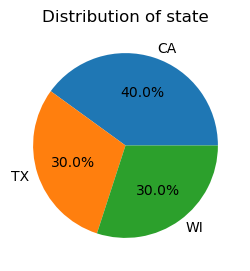

In [26]:
state = sales_train['state_id'].value_counts().sort_index() / sales_train['state_id'].value_counts().sum() * 100
fig = plt.figure(figsize=(3, 3))
plt.pie(state, labels=state.index, autopct='%1.1f%%')
plt.title('Distribution of state')
plt.show()

### 2. Store

Within each state with 3049 items in each store, there are 10 stores such as CA_1, CA_2, CA_3, and CA_4 in California.

In [27]:
sales_train['store_id'].nunique()

10

In [28]:
sales_train['store_id'].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

### 3. Category

There are 3 categories: **Hobbies, Household and Foods**. Within each categories, Foods accounts for almost half of the sales.

In [29]:
sales_train['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

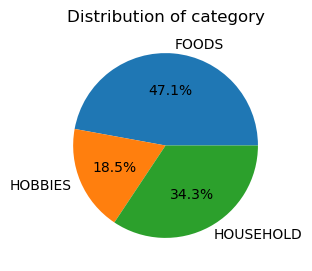

In [30]:
cat = sales_train['cat_id'].value_counts().sort_index() / sales_train['cat_id'].value_counts().sum() * 100
fig = plt.figure(figsize=(3, 3))
plt.pie(cat, labels=cat.index, autopct='%1.1f%%')
plt.title('Distribution of category')
plt.show()

In [38]:
sales_prods = sales_train.loc[:, 'd_1' : ]

# zero value in sales
zero = sales_prods.apply(lambda x: x == 0)
z = zero.sum(axis=1)
z = z/1913
sales_train['zero_days'] = z

# By category
hobbies = sales_train.loc[sales_train['cat_id']=='HOBBIES']
foods = sales_train.loc[sales_train['cat_id']=='FOODS']
household = sales_train.loc[sales_train['cat_id']=='HOUSEHOLD']

# Plot histogram
fig = go.Figure()
fig.add_trace(go.Histogram(x=hobbies['zero_days'],name='Hobbies'))
fig.add_trace(go.Histogram(x=foods['zero_days'],name='Foods'))
fig.add_trace(go.Histogram(x=household['zero_days'],name='Household'))
fig.update_layout(barmode='overlay',title_text='Distribution of Zero Values Across Categories',
                  xaxis_title_text='Proportion of 0 in sales', yaxis_title_text='Count of dates')
fig.update_traces(opacity=0.5)
fig.show()

### 4. Department

Within 7 departments, Foods_3 has about 8000 number of items in total, which is the highest one.

In [39]:
sales_train['dept_id'].unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

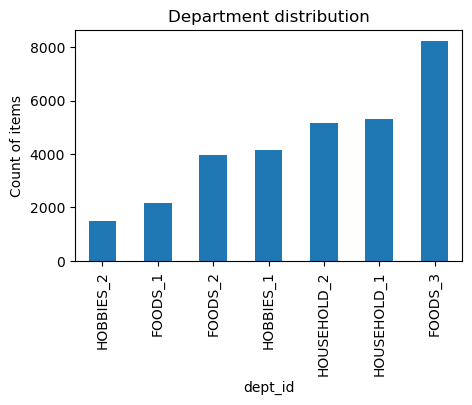

In [40]:
sales_train.groupby('dept_id').count()['id'].sort_values().plot(kind = 'bar', 
                                                                figsize=(5, 3), title='Department distribution',
                                                                ylabel = 'Count of items')
plt.show()

## (b) Prices

Sell_prices dataset is about daily price for 3049 items in the sales_train dataset across 10 stores.

In [41]:
sell_prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [42]:
sell_prices['item_id'].nunique()

3049

## (c) Calendar

- Calendar dataset contains: different time series levels such as date, month and year, event fields to mark the special holidays and their types, and snap day(Supplemental Nutritional Assistance Program) which refers to purchasing activity of low income households.
- It contains 1969 unique dates and all can be matched with sales_train dataset.

In [43]:
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [44]:
calendar['d'].unique()

array(['d_1', 'd_2', 'd_3', ..., 'd_1967', 'd_1968', 'd_1969'],
      dtype=object)

In [45]:
event = calendar.groupby(['event_type_1','event_name_1']).agg({'date': ['nunique']}).reset_index()
event.columns = ['event_type_1','event_name_1','days']

fig = px.bar(event, x='event_name_1', y='days', color='event_type_1')
fig.update_layout(title_text='Number of days by Event Name', xaxis_title_text='Event Type',yaxis_title_text='Number of Days')

fig.show()

There are more than 80% missing values in columns "event_name_2", "event_type_2", "event_name_1", "event_type_1".

In [46]:
calendar.isnull().sum()/len(calendar)

date            0.000000
wm_yr_wk        0.000000
weekday         0.000000
wday            0.000000
month           0.000000
year            0.000000
d               0.000000
event_name_1    0.917725
event_type_1    0.917725
event_name_2    0.997461
event_type_2    0.997461
snap_CA         0.000000
snap_TX         0.000000
snap_WI         0.000000
dtype: float64

## III. Time series analysis

### (a) Rolling mean sales trend

In [47]:
dcols = [d for d in sales_train.columns if 'd_' in d]
past_sales = sales_train.set_index('id')[dcols].T.merge(calendar.set_index('d')['date'],
                                                        left_index = True, right_index = True, validate = '1:1').set_index('date')

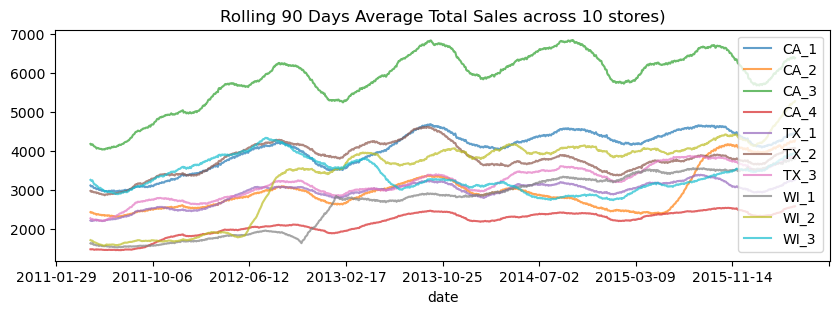

In [50]:
store_list = sell_prices['store_id'].unique()

for s in store_list:
    store_items = [p for p in past_sales.columns if s in p]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(10, 3),
              alpha=0.7,
              title='Rolling 90 Days Average Total Sales across 10 stores)')
plt.legend(store_list)
plt.show()

### (b) Cross sales distribution

In [136]:
# date_col = [col for col in sales_train if col.startswith('d_')]
dcols = [d for d in sales_train.columns if 'd_' in d]
sales_train['total_sales'] = sales_train[dcols].sum(axis=1)

Text(0.5, 23.38159722222222, 'dept_id')

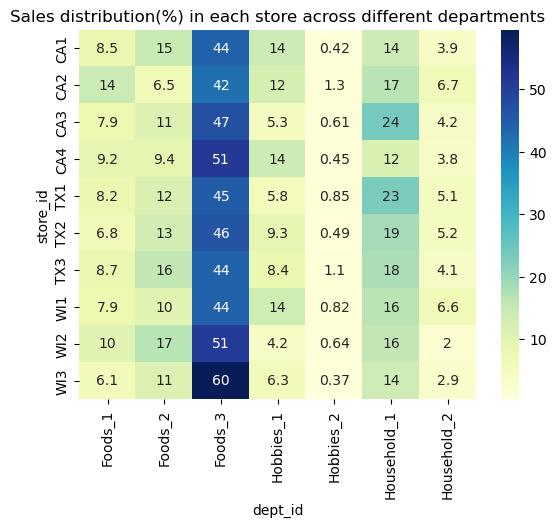

In [137]:
dist = sales_train.groupby(['store_id','dept_id']).agg({"total_sales":"sum"}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()
distplt = sns.heatmap(dist, annot=True, cmap="YlGnBu",
                xticklabels =['Foods_1','Foods_2','Foods_3','Hobbies_1','Hobbies_2','Household_1','Household_2'],
                yticklabels = ['CA1','CA2','CA3','CA4','TX1','TX2','TX3','WI1','WI2','WI3'])
plt.title("Sales distribution(%) in each store across different departments")
plt.xlabel('dept_id')

### (c) Average price trend

In [58]:
calendar = pd.read_csv('calendar.csv')
sell_prices = pd.read_csv('sell_prices.csv')
sales_train = pd.read_csv('sales_train_validation.csv')

In [59]:
cols = ['date','wm_yr_wk','d','weekday','month','year','event_type_1','snap_CA','snap_TX','snap_WI']
calendar_1 = calendar[cols]

In [60]:
rows=int(sales_train.shape[0]/4)
sales_train=sales_train.sample(rows, replace=True)
sales_train_l=sales_train.melt(['id','item_id','dept_id','cat_id','store_id','state_id'], var_name='d', value_name='amount')

sales_train_2 = pd.merge(left=sales_train_l,right=calendar_1,left_on='d', right_on='d')
sales_train_2['event_type_1']=sales_train_2['event_type_1'].fillna('No Event')
sales_train_3 = pd.merge(left=sales_train_2,right=sell_prices,left_on=['store_id','item_id','wm_yr_wk'],right_on=['store_id','item_id','wm_yr_wk'])

In [138]:
sales_train_3.head()

id      item_id  dept_id cat_id store_id state_id  \
0  FOODS_2_133_CA_1_validation  FOODS_2_133  FOODS_2  FOODS     CA_1       CA   
1  FOODS_2_133_CA_1_validation  FOODS_2_133  FOODS_2  FOODS     CA_1       CA   
2  FOODS_2_133_CA_1_validation  FOODS_2_133  FOODS_2  FOODS     CA_1       CA   
3  FOODS_2_133_CA_1_validation  FOODS_2_133  FOODS_2  FOODS     CA_1       CA   
4  FOODS_2_133_CA_1_validation  FOODS_2_133  FOODS_2  FOODS     CA_1       CA   

     d  amount        date  wm_yr_wk    weekday  month  year event_type_1  \
0  d_1       0  2011-01-29     11101   Saturday      1  2011     No Event   
1  d_2       2  2011-01-30     11101     Sunday      1  2011     No Event   
2  d_3       0  2011-01-31     11101     Monday      1  2011     No Event   
3  d_4       0  2011-02-01     11101    Tuesday      2  2011     No Event   
4  d_5       0  2011-02-02     11101  Wednesday      2  2011     No Event   

   snap_CA  snap_TX  snap_WI  sell_price  
0        0        0        0        2.98  
1        0        0        0        2.98  
2        0        0        0        2.98  
3        1        1        0        2.98  
4        1        0        1        2.98

In [78]:
# average price
price_cat = sales_train_3.groupby(['date','cat_id'],as_index=False)['sell_price'].mean().dropna()
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Scatter(x=price_cat[price_cat['cat_id']=='HOBBIES']['date'], 
                         y=price_cat[price_cat['cat_id']=='HOBBIES']['sell_price'],name='HOBBIES'), row=1, col=1)
fig.add_trace(go.Scatter(x=price_cat[price_cat['cat_id']=='HOUSEHOLD']['date'],
               y=price_cat[price_cat['cat_id']=='HOUSEHOLD']['sell_price'],name='HOUSEHOLD'),row=1, col=2)
fig.add_trace(go.Scatter(x=price_cat[price_cat['cat_id']=='FOODS']['date'],
                         y=price_cat[price_cat['cat_id']=='FOODS']['sell_price'],name='FOODS'),row=1, col=3)

fig.update_layout(title_text='Average Price in 3 categories',yaxis_title_text='Price',width=800, height=400)
fig.show()

In [75]:
### aggregation

# daily 
daily=sales_train_3.groupby('date').agg({'qty': ['mean']}).reset_index()
daily.columns=['date','qty']

# State
state=sales_train_3.groupby(['state_id','date']).agg({'qty': ['mean']}).reset_index()
state.columns=['state_id','date','qty']

# dept
dept_sales=sales_train_3.groupby(['dept_id','date']).agg({'qty': ['sum']}).reset_index()
dept_sales.columns=['dept_id','date','qty']

# weekday
weekday=sales_train_3.groupby(['weekday']).agg({'qty': ['mean']}).reset_index()
weekday.columns=['weekday','qty']

# category
cat=sales_train_3.groupby(['cat_id','date']).agg({'qty': ['mean']}).reset_index()
cat.columns=['cat_id','date','qty']

### year
# state
year_state=sales_train_3.groupby(['year','state_id']).agg({'qty': ['mean']}).reset_index()
year_state.columns=['year','state_id','qty']
# store
store=sales_train_3.groupby(['store_id','year']).agg({'qty': ['mean']}).reset_index()
store.columns=['store_id','date','qty']

### weekday
weekday=sales_train_3.groupby(['weekday']).agg({'qty': ['mean']}).reset_index()
weekday.columns=['weekday','qty']
# cat
weekday_cat=sales_train_3.groupby(['weekday','cat_id']).agg({'qty': ['mean']}).reset_index()
weekday_cat.columns=['weekday','cat_id','qty']
# state
weekday_state=sales_train_3.groupby(['weekday','state_id']).agg({'qty': ['mean']}).reset_index()
weekday_state.columns=['weekday','state_id','qty']

### monthly
month=sales_train_3.groupby(['month']).agg({'qty': ['mean']}).reset_index()
month.columns=['month','qty']
# cat
month_cat=sales_train_3.groupby(['month','cat_id']).agg({'qty': ['mean']}).reset_index()
month_cat.columns=['month','cat_id','qty']
# state
month_state=sales_train_3.groupby(['month','state_id']).agg({'qty': ['mean']}).reset_index()
month_state.columns=['month','state_id','qty']

### (d) Total sales trend

In [85]:
fig = go.Figure()
dept_list=['FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2','HOUSEHOLD_1', 'HOUSEHOLD_2']

for d in range(7):
  subset = dept_sales[dept_sales['dept_id']==dept_list[d]]
  fig.add_trace(go.Scatter(x=subset['date'], y=subset['qty'], mode='lines',name=dept_list[d]))

fig.update_layout(title='Total sales amount in 7 departments by date',xaxis_title_text='Date',yaxis_title_text='Sales')
fig.show()

In [86]:
fig = go.Figure()
state_list=['CA','TX','WI']

for s in range(3):
  subset=state[state['state_id']==state_list[s]]
  fig.add_trace(go.Scatter(x=subset['date'], y=subset['qty'], mode='lines', name=state_list[s]))

fig.update_layout(title='Total sales amount in 3 states by date',xaxis_title_text='Year',yaxis_title_text='Sales')
fig.show()

### (e) Sales distribution accross store

In [153]:
# fig = make_subplots(rows=1, cols=3)

fig = go.Figure()
state_list=['CA','TX','WI']

# By year
for s in range(3):
  subset=year_state[year_state['state_id']==state_list[s]]
  fig.add_trace(go.Scatter(x=subset['year'], y=subset['qty'], mode='lines', name=state_list[s]))

fig.update_layout(title='Sales Trend in 3 states by year',xaxis_title_text='Year',yaxis_title_text='Sales',
                  width=400, height=400)
fig.show()

# By month
fig = go.Figure()
for s in range(3):
  subset=month_state[month_state['state_id']==state_list[s]]
  fig.add_trace(go.Scatter(x=subset['month'], y=subset['qty'],mode='lines',name=state_list[s]))

fig.update_layout(title='Sales Trend in 3 states by month', xaxis_title_text='Month',yaxis_title_text='Sales', width=400, height=400)
fig.show()

# By weekday
fig = go.Figure()
for s in range(3):
  subset=weekday_state[weekday_state['state_id']==state_list[s]]
  fig.add_trace(go.Bar(x=subset['weekday'], y=subset['qty'], name=state_list[s]))
fig.update_xaxes(categoryorder='array', categoryarray= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
fig.update_layout(title='Sales Trend in 3 states by weekday',xaxis_title_text='Weekday',yaxis_title_text='Sales',
                  width=400, height=400)
fig.show()

In [101]:
qty_cat = sales_train_3.groupby(['year','date','state_id','store_id'],as_index=False)['amount'].sum().dropna()

fig = px.box(qty_cat, x='store_id', color='state_id',y='amount') 
fig.update_layout(template='seaborn',title='Total sales amount distribution for 10 stores',legend_title_text='State'
                  ,yaxis_title="sales amount")

fig.show()

In [124]:
qty_cat.describe()

year        amount
count  19130.000000  19130.000000
mean    2013.209096    875.037219
std        1.532126    346.693089
min     2011.000000      0.000000
25%     2012.000000    633.000000
50%     2013.000000    808.000000
75%     2015.000000   1042.000000
max     2016.000000   2779.000000

In [130]:
qty_cat.groupby(['state_id','store_id'],as_index=False)['amount'].mean().dropna()
# qty_cat = sales_train_3.groupby(['year','date','state_id','store_id'],as_index=False)['amount'].sum().dropna()

state_id store_id       amount
0       CA     CA_1   985.887088
1       CA     CA_2   754.878202
2       CA     CA_3  1472.223210
3       CA     CA_4   584.679561
4       TX     TX_1   700.600105
5       TX     TX_2   861.716675
6       TX     TX_3   794.376895
7       WI     WI_1   614.392054
8       WI     WI_2   970.562990
9       WI     WI_3  1011.055410

In [131]:
qty_cat.groupby(['state_id','store_id'],as_index=False)['amount'].var().dropna()

state_id store_id         amount
0       CA     CA_1   53759.025947
1       CA     CA_2   62139.035890
2       CA     CA_3  127229.183938
3       CA     CA_4   13504.194859
4       TX     TX_1   28484.026715
5       TX     TX_2   33364.051484
6       TX     TX_3   28665.699403
7       WI     WI_1   53088.176757
8       WI     WI_2  123903.472102
9       WI     WI_3   77737.491698

### (f) Sales distribution accross category

In [118]:
cat_level = sales_train.groupby("cat_id")[dcols].sum().reset_index().set_index('cat_id').T
base = datetime.datetime(2011,1,29)
cat_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
cat_level.set_index('datum', drop=True, inplace=True)
cat_level.sort_index(inplace=True)

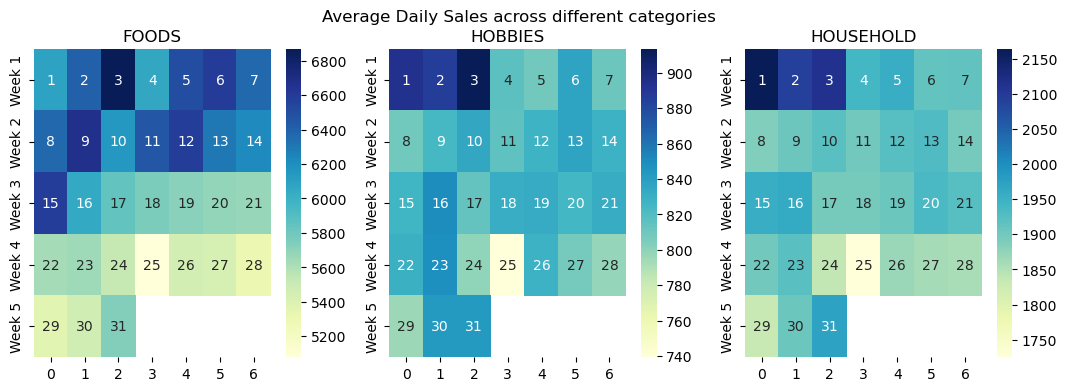

In [135]:
cat_monthly_sales = cat_level.groupby(cat_level.index.strftime('%d')).mean()
foods_list = np.array(cat_monthly_sales['FOODS'].tolist())
foods_list = np.append(foods_list, np.repeat(np.nan, 4)).reshape(5,7)
hobbies_list = np.array(cat_monthly_sales['HOBBIES'].tolist())
hobbies_list = np.append(hobbies_list, np.repeat(np.nan, 4)).reshape(5,7)
household_list = np.array(cat_monthly_sales['HOUSEHOLD'].tolist())
household_list = np.append(household_list, np.repeat(np.nan, 4)).reshape(5,7)
labels = range(1,32)
labels = np.append(labels, np.repeat(np.nan, 4)).reshape(5,7)

fig, (ax1, ax2 , ax3) = plt.subplots(1,3)
fig.set_size_inchJes(13, 4, forward=True)
foods_map= sns.heatmap(foods_list,cmap = "YlGnBu",annot = labels, yticklabels = ("Week 1","Week 2","Week 3","Week 4","Week 5"), ax =ax1)
hobbies_map= sns.heatmap(hobbies_list,cmap = "YlGnBu",annot = labels, yticklabels = ("Week 1","Week 2","Week 3","Week 4","Week 5"), ax =ax2)
household_map= sns.heatmap(household_list,cmap = "YlGnBu",annot = labels, yticklabels = ("Week 1","Week 2","Week 3","Week 4","Week 5"), ax =ax3)
ax1.set_title('FOODS')
ax2.set_title('HOBBIES')
ax3.set_title('HOUSEHOLD')

plt.suptitle("Average Daily Sales across different categories ")
plt.show()